先定义加载文件路径，画图和保存的函数

In [44]:
import numpy as np
from pathlib import Path
import gzip
import pickle



def load_data(path):
    with gzip.open(Path(path).as_posix(), 'rb') as f:
        ((train_X, train_y), (test_X, test_y), _) = pickle.load(f, encoding='latin-1')
    # n = train_y.shape[0]
    # train_y_vector = np.zeros((n, 10))
    # for i in range(n):
    #     train_y_vector[i][train_y[i]] = 1
    return train_X, train_y, test_X, test_y


def get_batch(n, batch_size):
    batch_step = np.arange(0, n, batch_size)
    indices = np.arange(n, dtype=np.int64)
    np.random.shuffle(indices)
    batches = [indices[i: i + batch_size] for i in batch_step]
    return batches


def accuracy(y_true, y_pred):
    return len(np.where(y_true==y_pred)[0]) / len(y_true)


In [45]:
import matplotlib.pyplot as plt


def show_image(data):
    plt.imshow(data.reshape((28, 28)), cmap='gray')


def plot_loss(path, loss_train, loss_test):
    plt.figure(dpi=150)
    plt.title('losscurve')
    plt.plot(loss_train)
    plt.plot(loss_test)
    plt.legend(['train', 'test'])
    plt.savefig(path+'losscurve.jpg')


def plot_acc(path, acc):
    plt.figure(dpi=150)
    plt.title('acc_curve')
    plt.plot(acc)
    plt.savefig(path+'acc_curve.jpg')


In [46]:
import xlwt

def save_metrics(path, train_loss, test_loss, acc):
    f = xlwt.Workbook()
    sheet1 = f.add_sheet(u'sheet1', cell_overwrite_ok=True)

    names = ['train_loss', 'test_loss', 'acc']
    for j in range(len(names)):
        sheet1.write(0, j, names[j])
        for i in range(len(acc)):
            sheet1.write(i+1, j, eval(names[j])[i])
    f.save(path+'metircs.xlsx')

In [47]:
import numpy as np
import math

class NeuralNetwork:
    def __init__(self, Input, hidden, output, regularization):
        self.Input = Input
        self.hidden = hidden
        self.output = output
        self.regularization = regularization

        self.w1 = np.random.randn(self.hidden, self.Input)
        self.b1 = np.random.randn(self.hidden)
        self.w2 = np.random.randn(self.output, self.hidden)
        self.b2 = np.random.randn(self.output)

    # 正向传播
    def __call__(self, data):
        self.x = data

        self.z1 = np.add(np.dot(self.w1, data.T), self.b1.reshape(-1, 1))
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.add(np.dot(self.w2, self.a1), self.b2.reshape(-1, 1))
        self.a2 = self.softmax(self.z2.T)
        self.y_pred = np.argmax(self.a2, axis=1)
        return self.y_pred

    # sigmoid 激活函数
    @staticmethod
    def sigmoid(x):
        if np.all(x >= 0):
            return 1. / (1.+np.exp(-x))
        else:
            return np.exp(x) / (1. + np.exp(x))
    # softmax 激活函数
    @staticmethod
    def softmax(x):
        return np.divide(np.exp(x), np.sum(np.exp(x), axis=1).reshape(-1, 1))

    def loss(self, y_true):
        self.y_true = y_true
        n = len(y_true)
        loss = -np.sum(np.log(self.a2[np.arange(n), y_true])) / n
        return loss

    # 反向传播
    def backward(self, lr_start, epoch):
        lr_end = 0.0001
        lr_decay = 100
        #学习率下降策略
        lr = lr_end + (lr_start - lr_end) * math.exp(-epoch/lr_decay)

        self.z2_grad = self.a2.copy()
        n = len(self.y_true)
        self.z2_grad[np.arange(n), self.y_true] -= 1

        self.w2_grad = self.z2_grad.T.reshape(self.output, 1, len(self.y_true)) * self.a1
        self.b2_grad = self.z2_grad.T

        
        self.z1_grad = np.dot(self.z2_grad, self.w2).T * self.a1 * (1-self.a1)
        self.w1_grad = self.z1_grad.reshape(self.hidden, 1, len(self.y_true)) * self.x.T
        self.b1_grad = self.z1_grad

        self.w2_grad = np.sum(self.w2_grad, axis=2) + 2 * self.regularization * self.w2
        self.w1_grad = np.sum(self.w1_grad, axis=2) + 2 * self.regularization * self.w1
        self.b2_grad = np.sum(self.b2_grad, axis=1) + 2 * self.regularization * self.b2
        self.b1_grad = np.sum(self.b1_grad, axis=1) + 2 * self.regularization * self.b1

        self.w2 -= lr * self.w2_grad
        self.b2 -= lr * self.b2_grad
        self.w1 -= lr * self.w1_grad
        self.b1 -= lr * self.b1_grad

    # 保存模型
    def save(self, path):
        np.savez(path, w1=self.w1, b1=self.b1, w2=self.w2, b2=self.b2)

    # 加载模型
    def load(self, path):
        parameters = np.load(path)
        self.w1 = parameters['w1']
        self.b1 = parameters['b1']
        self.w2 = parameters['w2']
        self.b2 = parameters['b2']

lr_start:0.1, hiddenlayer_num:25, regulaization:0.1
epoch:1/100	   train_loss:0.77	  test_loss:0.7	 acc:79.68%.
epoch:2/100	   train_loss:0.59	  test_loss:0.51	 acc:84.16%.
epoch:3/100	   train_loss:0.6	  test_loss:0.62	 acc:83.06%.
epoch:4/100	   train_loss:0.63	  test_loss:0.69	 acc:81.59%.
epoch:5/100	   train_loss:0.59	  test_loss:0.96	 acc:76.55%.
epoch:6/100	   train_loss:0.59	  test_loss:0.58	 acc:84.26%.
epoch:7/100	   train_loss:0.57	  test_loss:0.67	 acc:81.66%.
epoch:8/100	   train_loss:0.54	  test_loss:0.86	 acc:78.37%.
epoch:9/100	   train_loss:0.5	  test_loss:0.65	 acc:81.15%.
epoch:10/100	   train_loss:0.54	  test_loss:0.55	 acc:83.14%.
epoch:11/100	   train_loss:0.5	  test_loss:0.63	 acc:83.79%.
epoch:12/100	   train_loss:0.5	  test_loss:0.54	 acc:86.66%.
epoch:13/100	   train_loss:0.51	  test_loss:0.47	 acc:88.61%.
epoch:14/100	   train_loss:0.47	  test_loss:0.66	 acc:79.33%.
epoch:15/100	   train_loss:0.51	  test_loss:1.02	 acc:68.75%.
epoch:16/100	   train_loss:0.51	

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


lr_start:0.1, hiddenlayer_num:200, regulaization:0.001
epoch:1/100	   train_loss:1.75	  test_loss:0.56	 acc:83.5%.
epoch:2/100	   train_loss:0.23	  test_loss:0.39	 acc:88.57%.
epoch:3/100	   train_loss:0.16	  test_loss:0.32	 acc:90.83%.
epoch:4/100	   train_loss:0.12	  test_loss:0.3	 acc:91.46%.
epoch:5/100	   train_loss:0.1	  test_loss:0.28	 acc:92.39%.
epoch:6/100	   train_loss:0.07	  test_loss:0.28	 acc:92.41%.
epoch:7/100	   train_loss:0.06	  test_loss:0.26	 acc:92.81%.
epoch:8/100	   train_loss:0.04	  test_loss:0.26	 acc:93.21%.
epoch:9/100	   train_loss:0.03	  test_loss:0.25	 acc:93.27%.
epoch:10/100	   train_loss:0.03	  test_loss:0.25	 acc:93.38%.
epoch:11/100	   train_loss:0.02	  test_loss:0.25	 acc:93.57%.
epoch:12/100	   train_loss:0.02	  test_loss:0.24	 acc:93.86%.
epoch:13/100	   train_loss:0.02	  test_loss:0.23	 acc:93.82%.
epoch:14/100	   train_loss:0.01	  test_loss:0.24	 acc:93.52%.
epoch:15/100	   train_loss:0.01	  test_loss:0.23	 acc:94.0%.
epoch:16/100	   train_loss:0

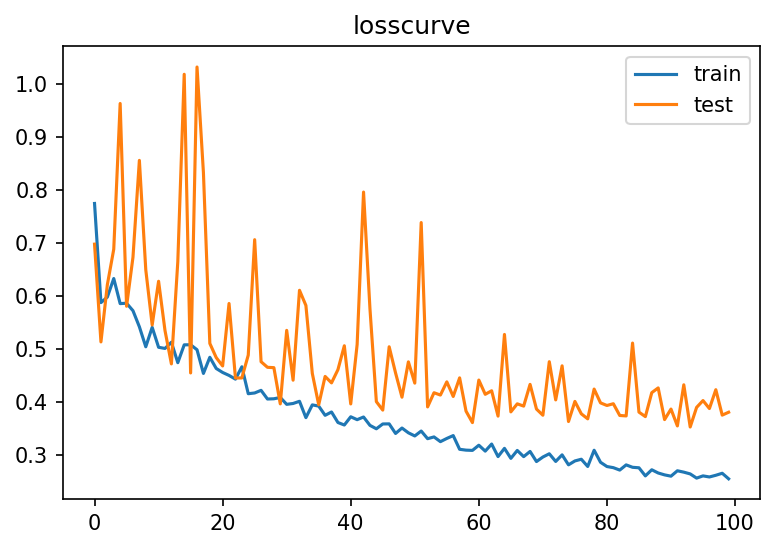

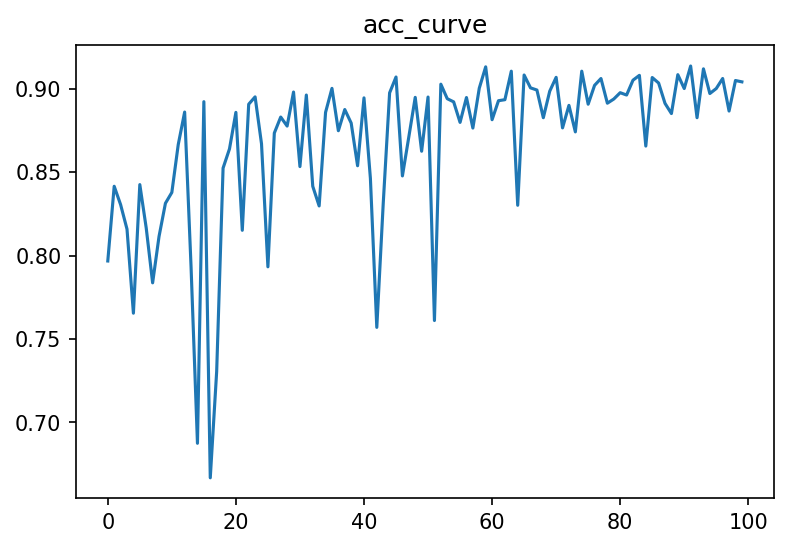

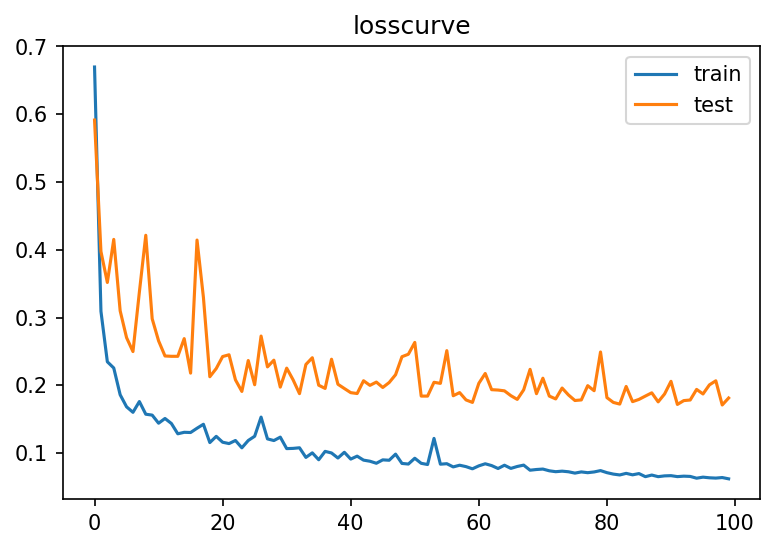

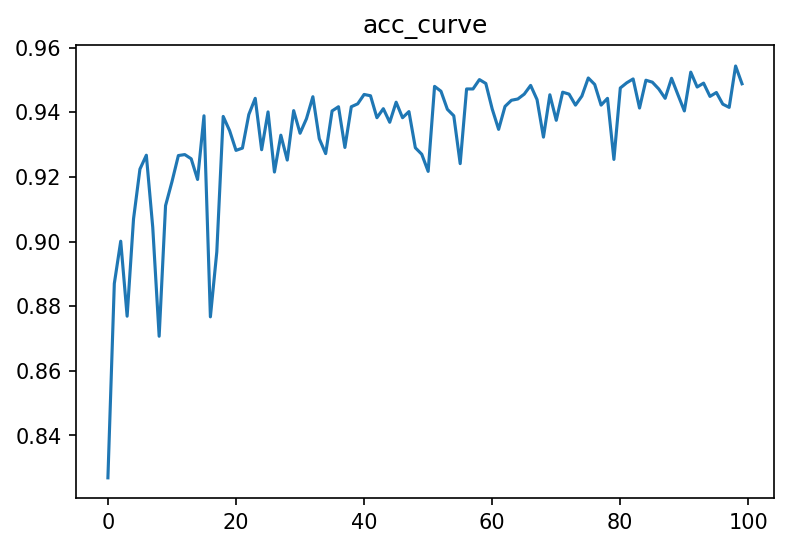

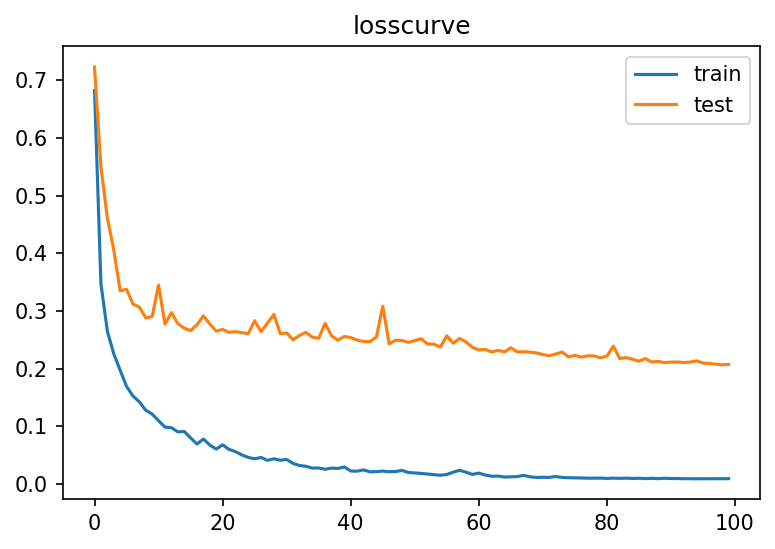

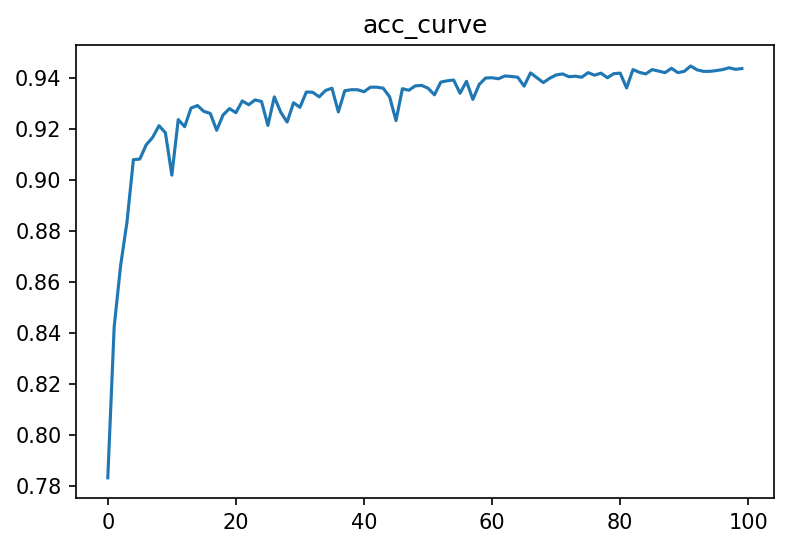

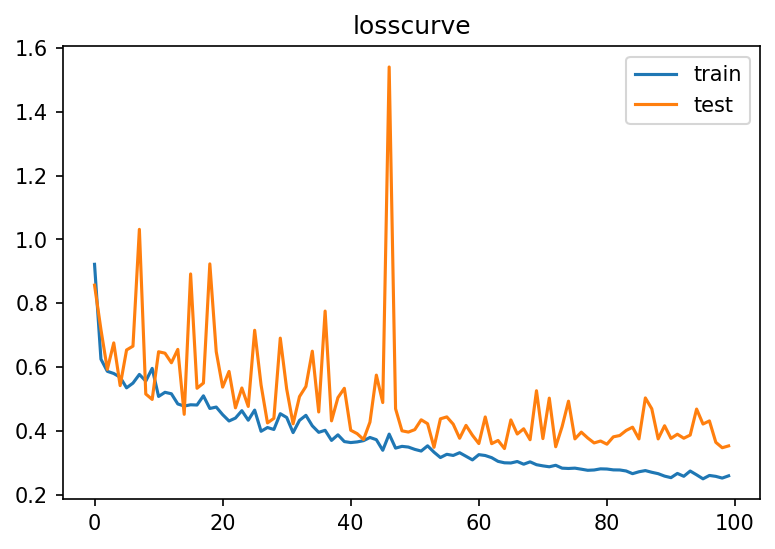

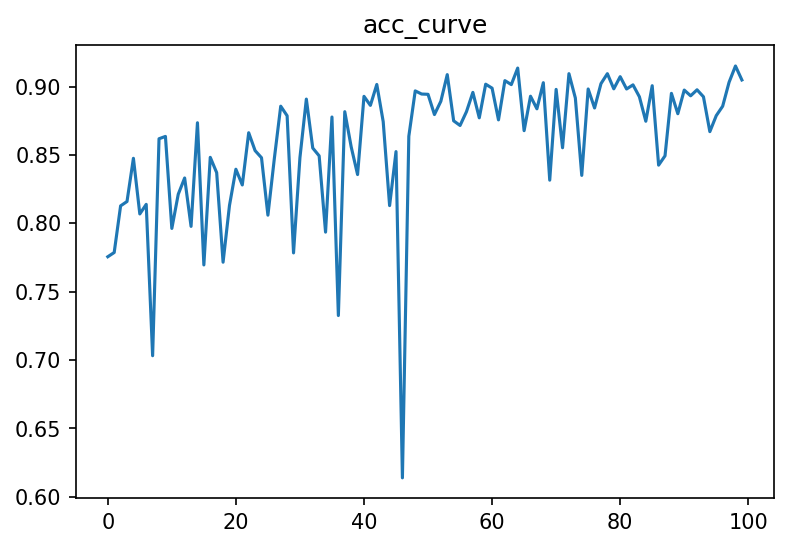

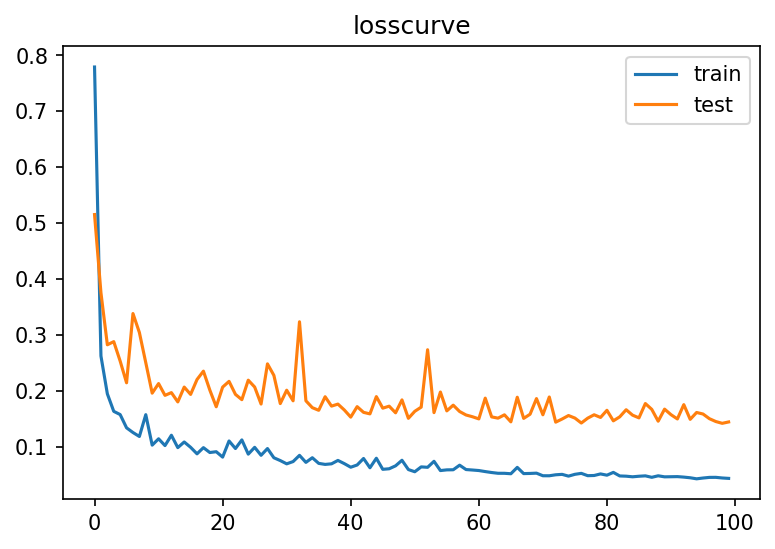

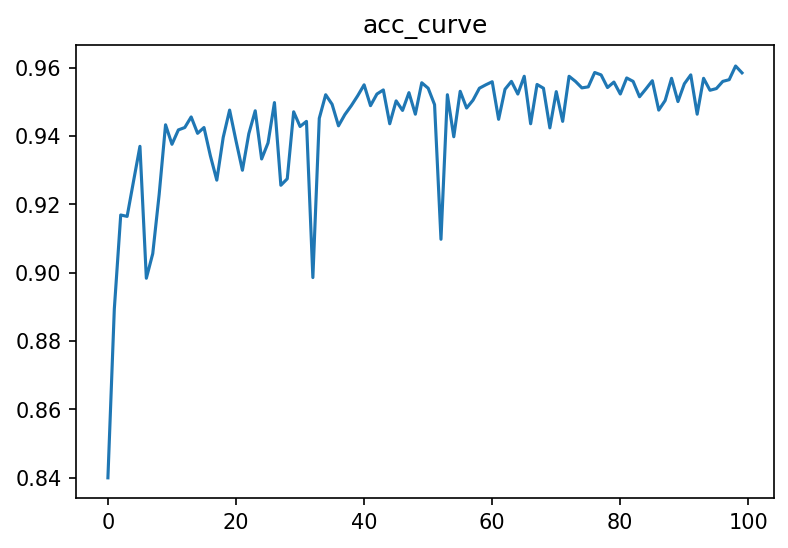

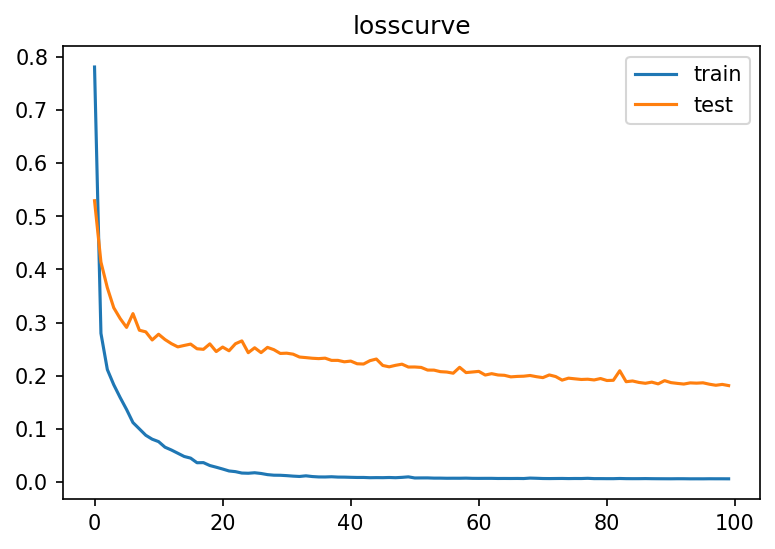

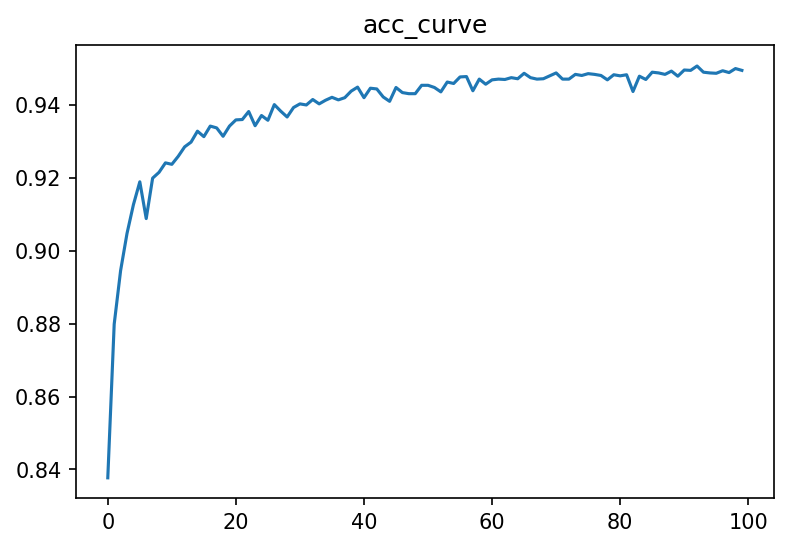

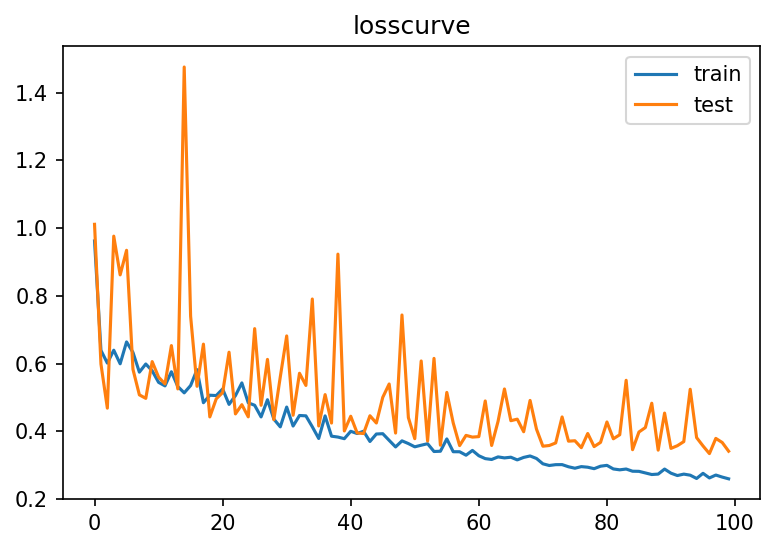

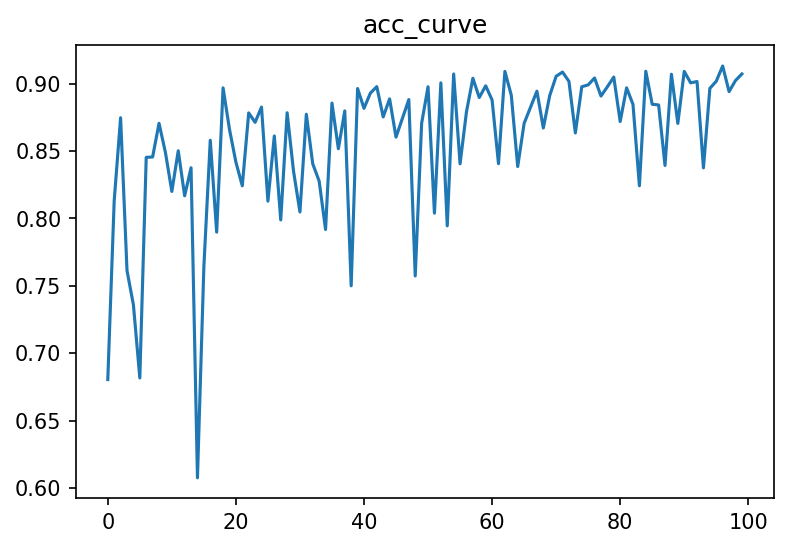

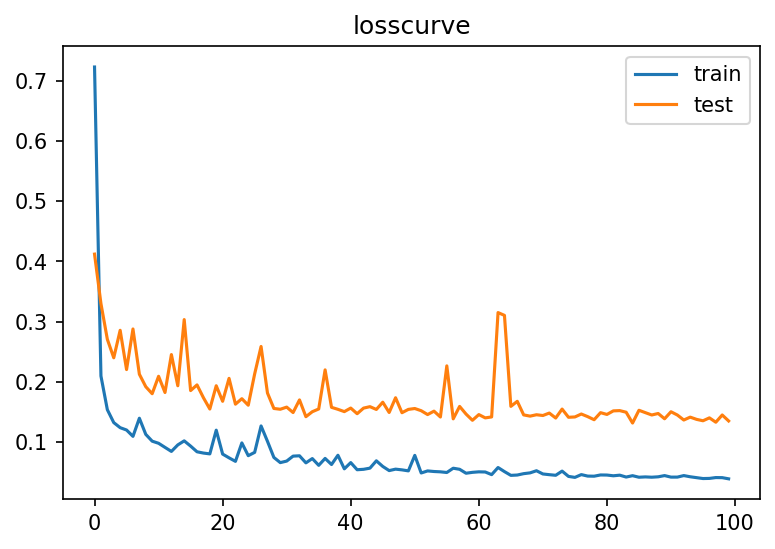

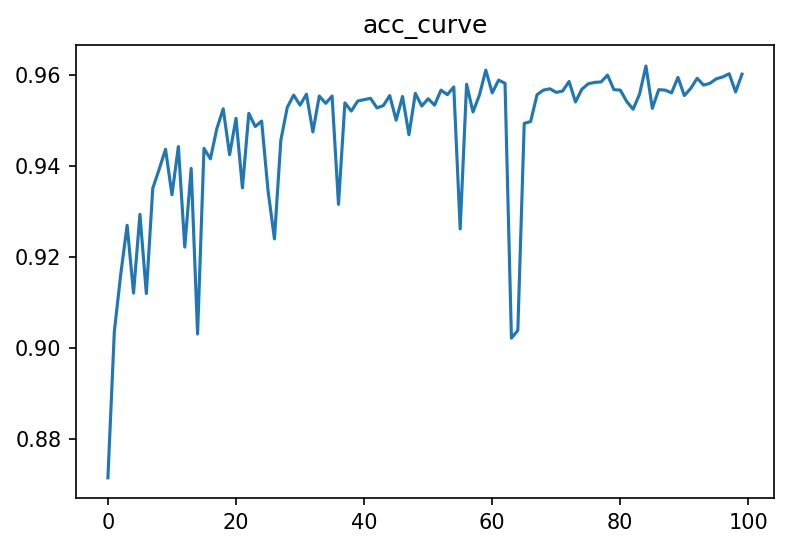

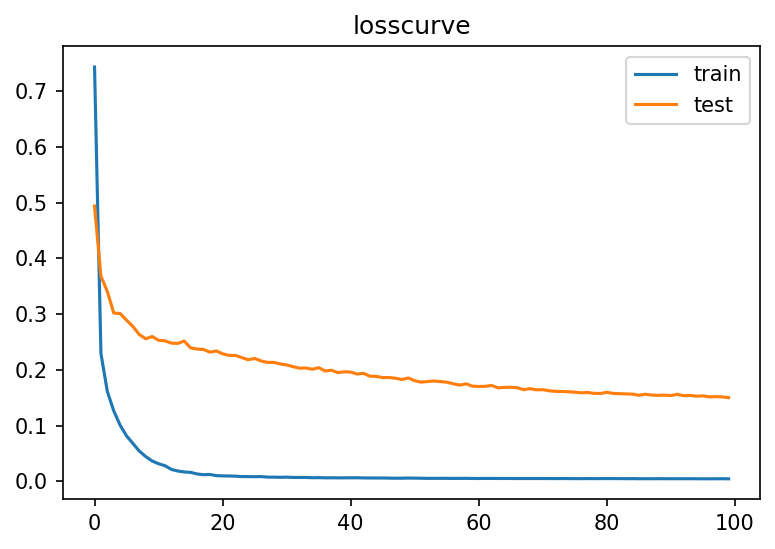

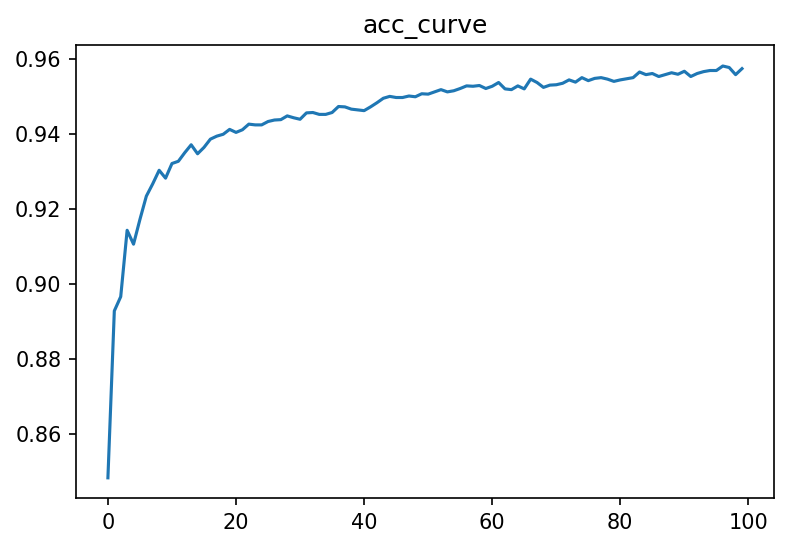

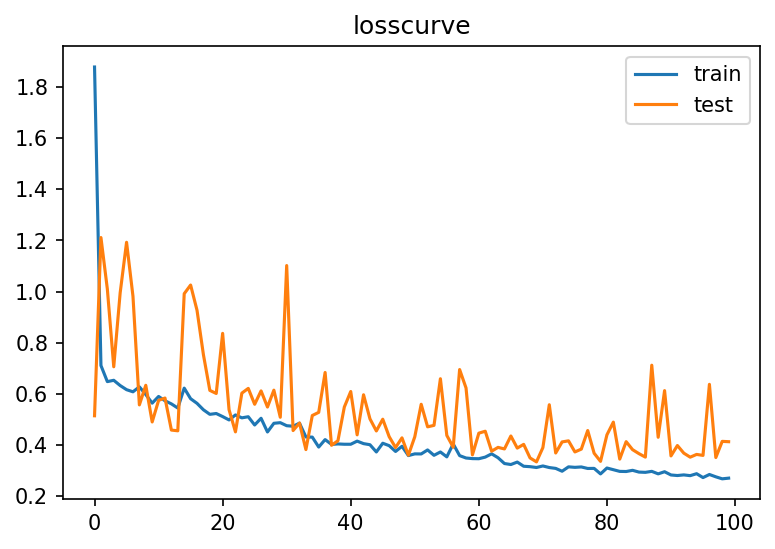

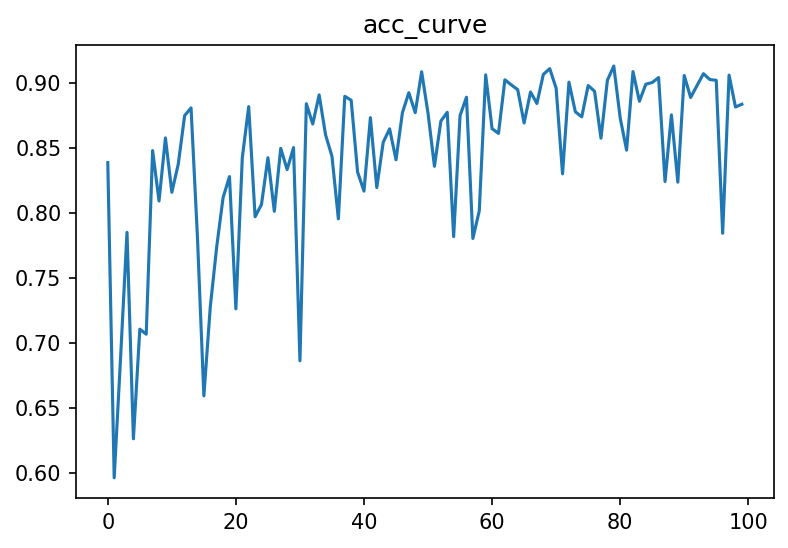

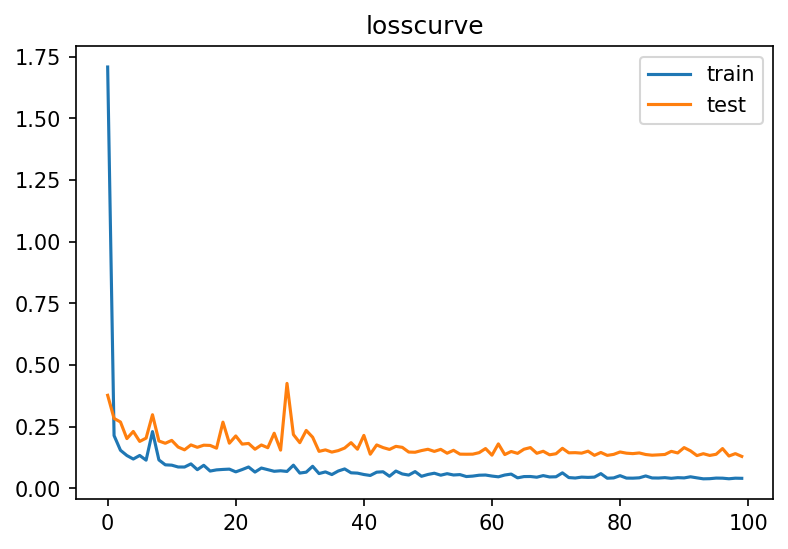

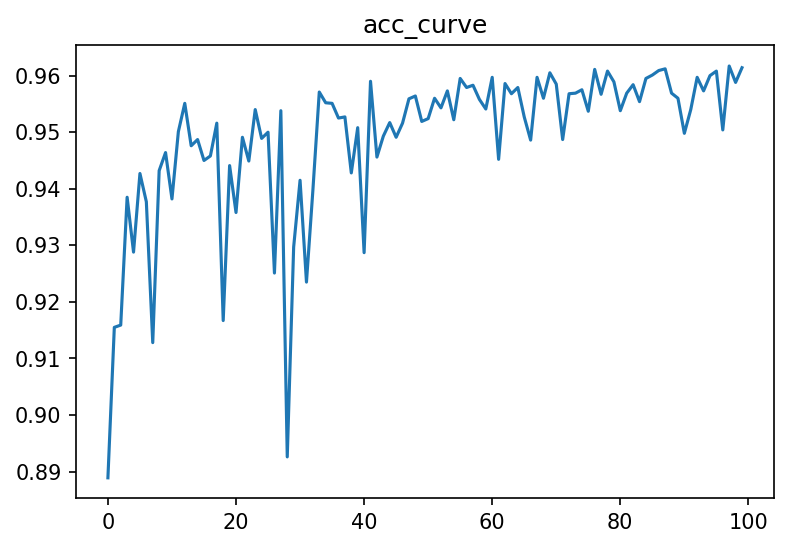

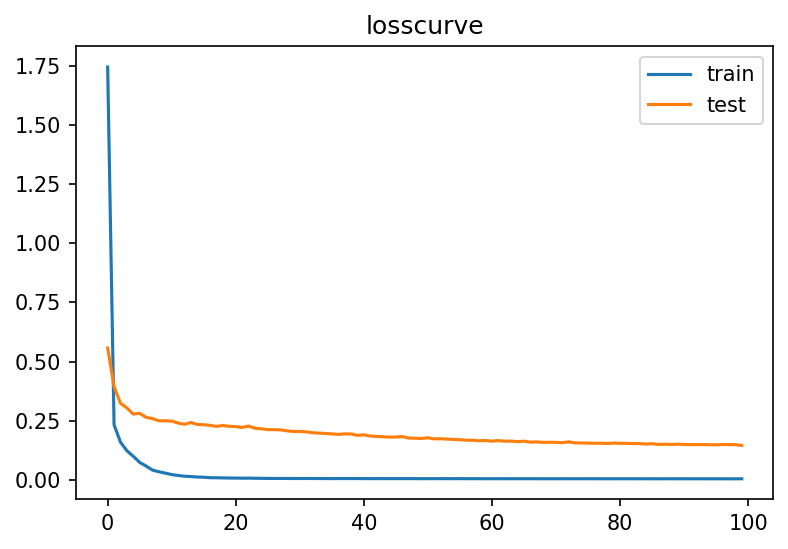

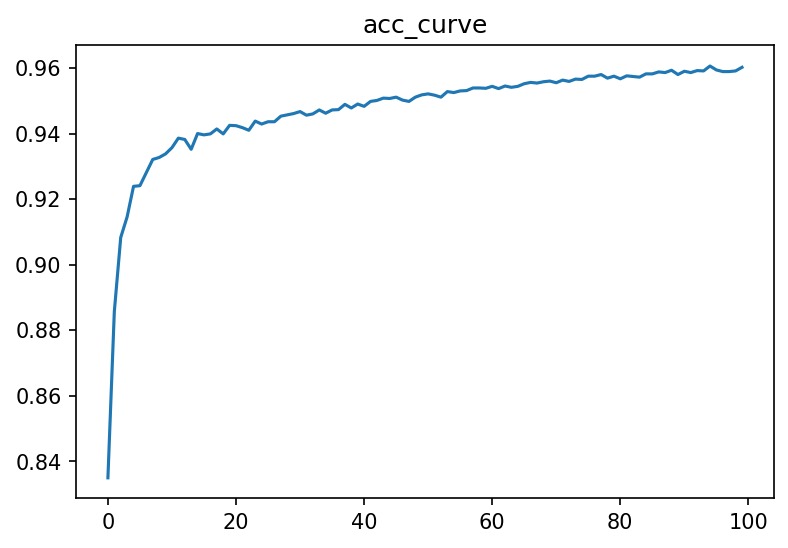

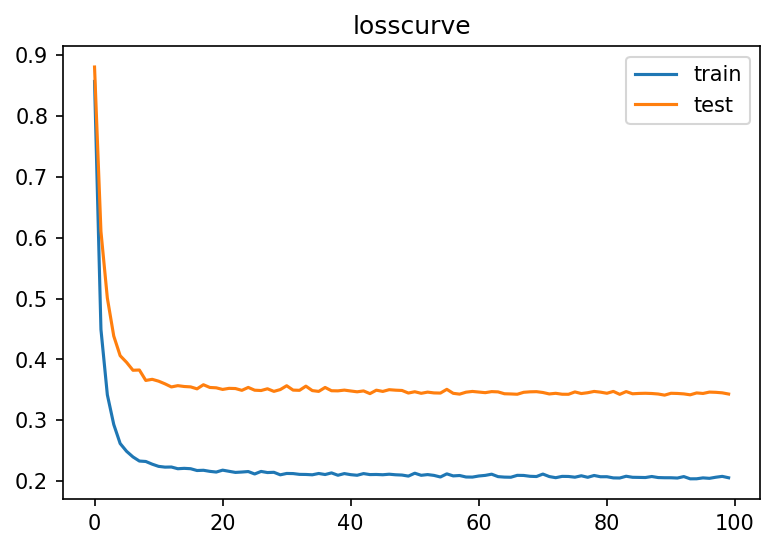

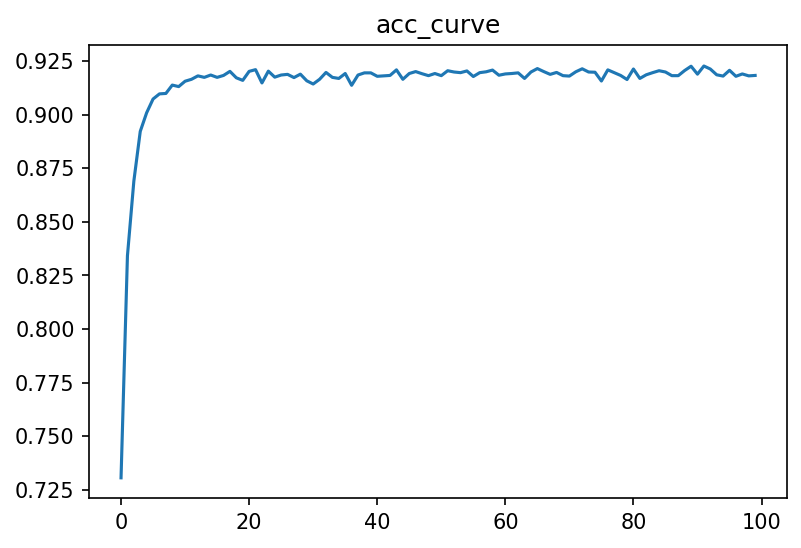

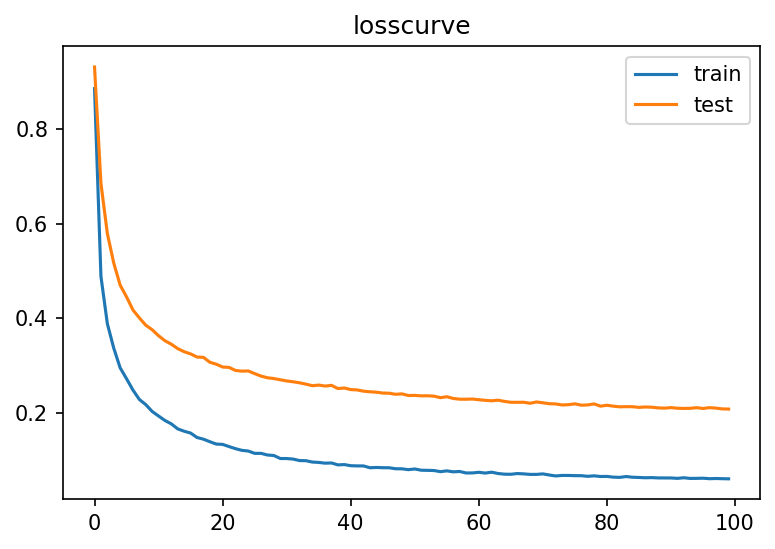

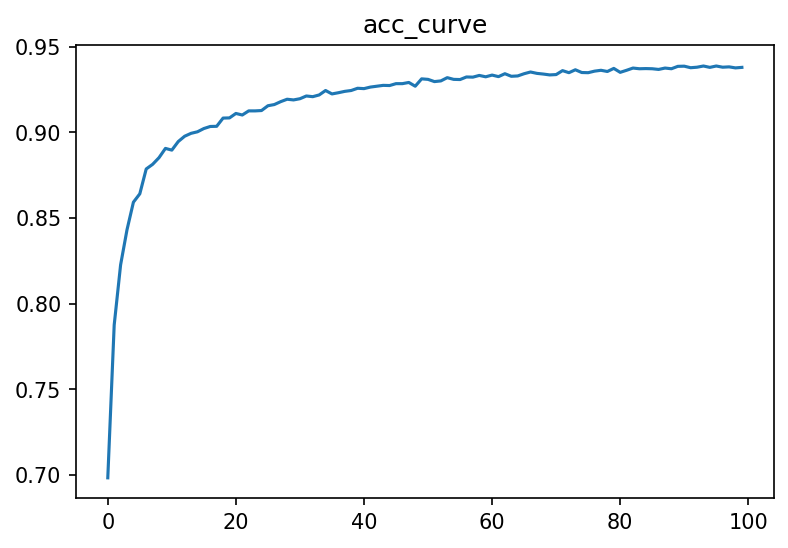

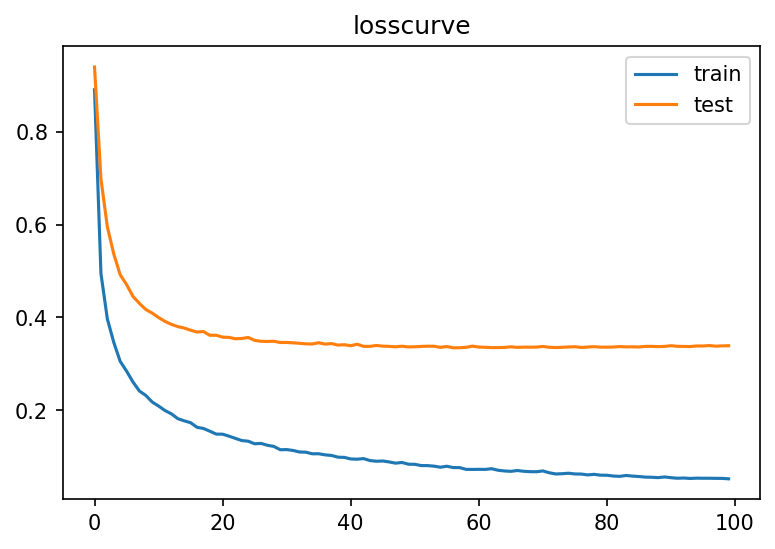

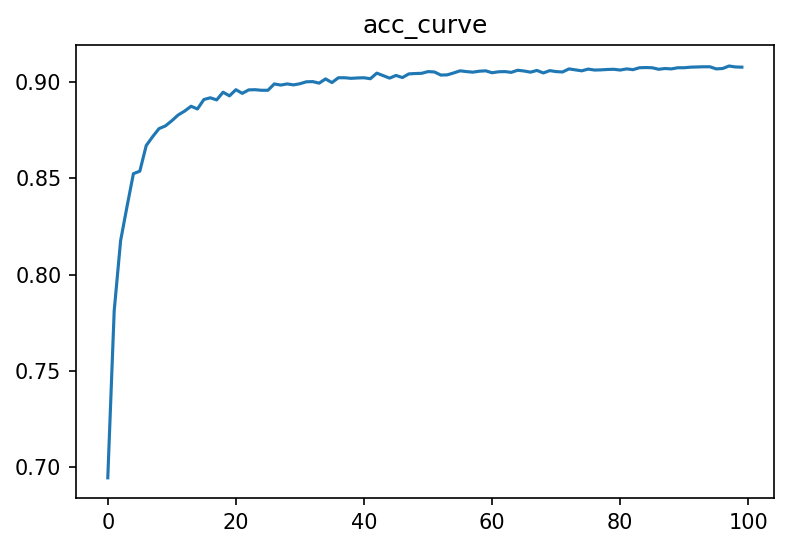

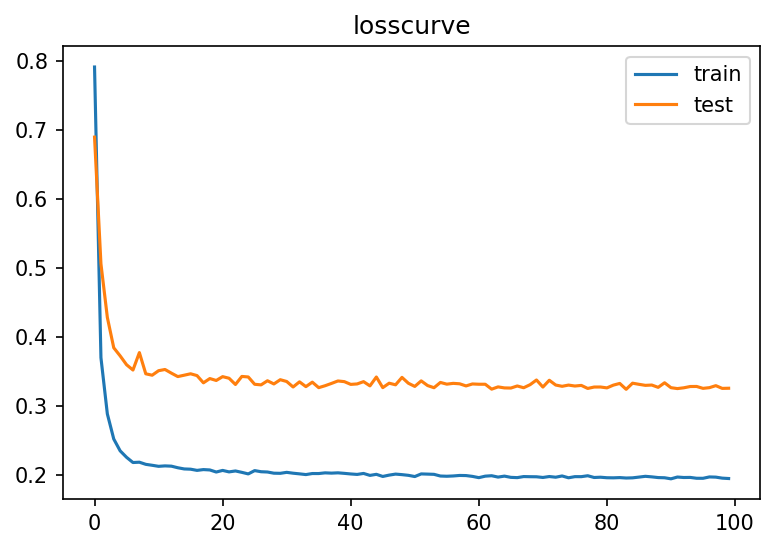

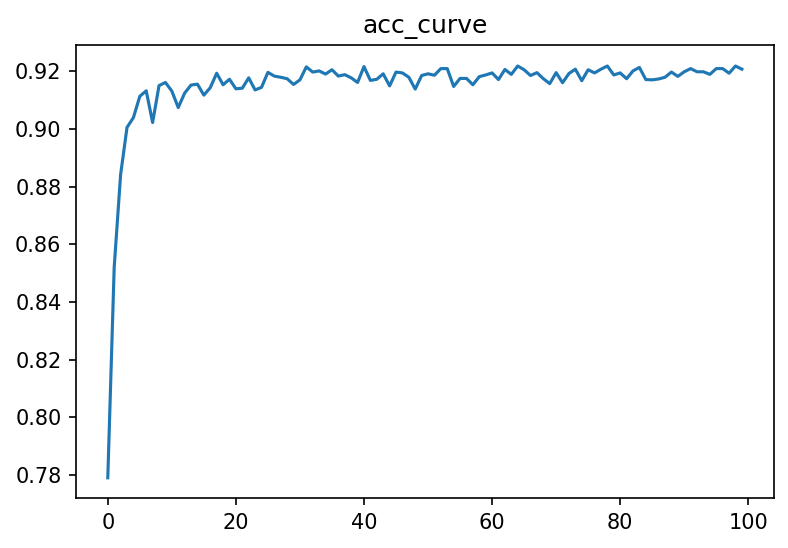

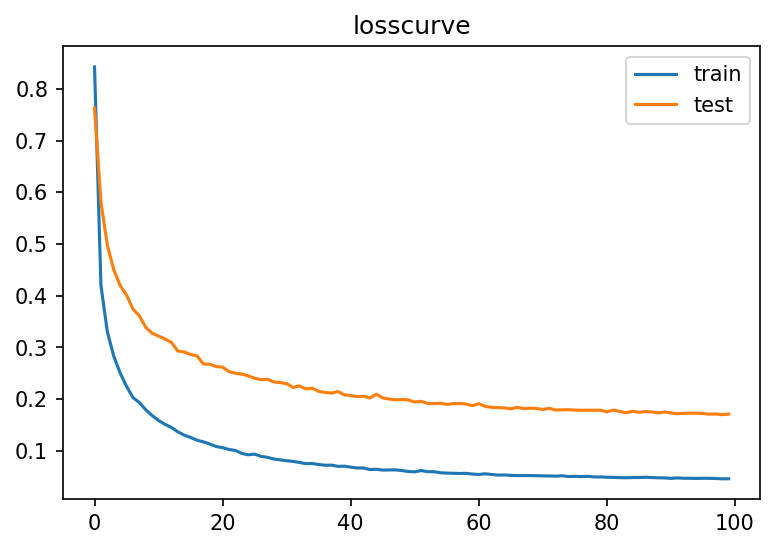

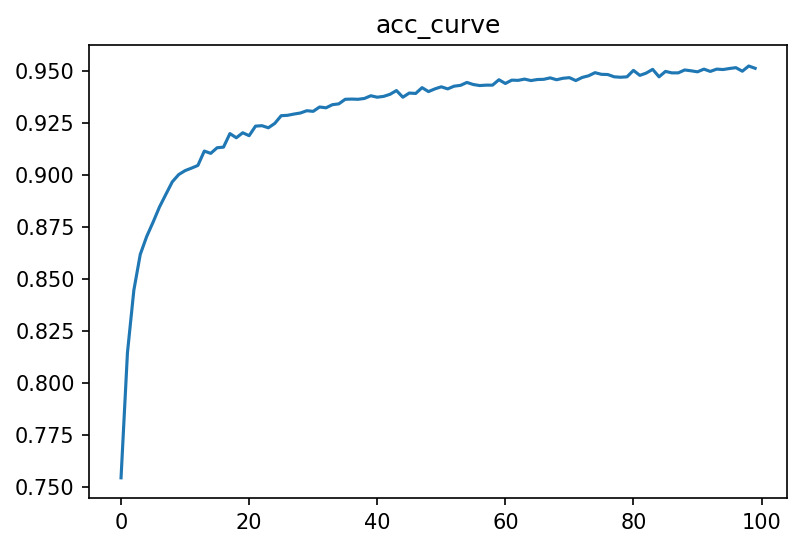

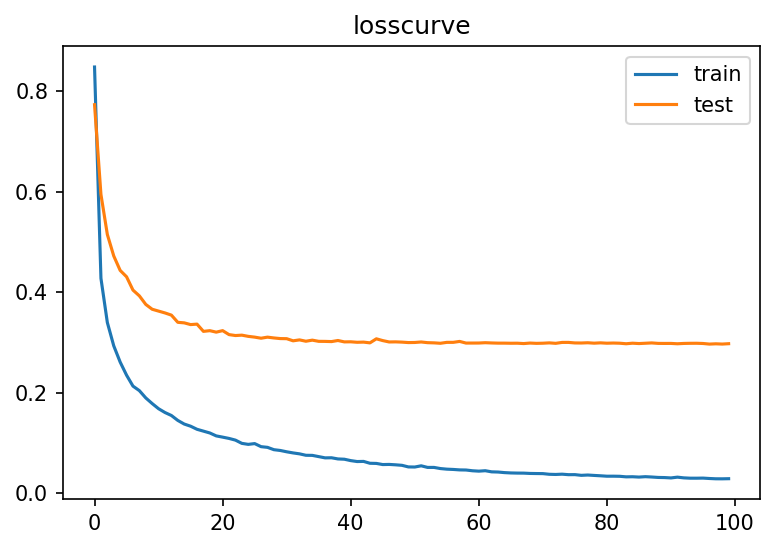

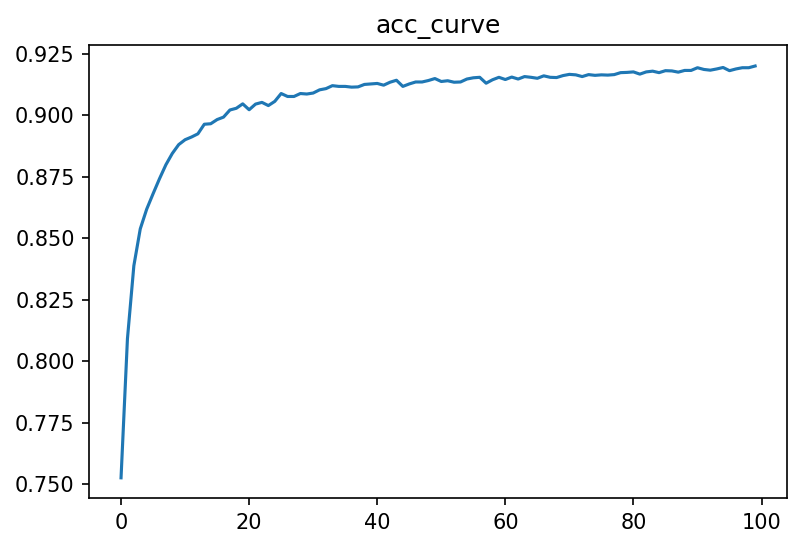

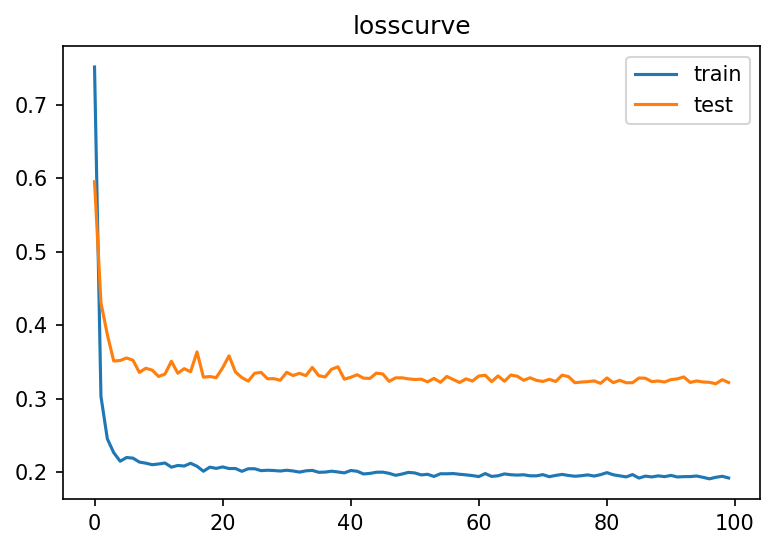

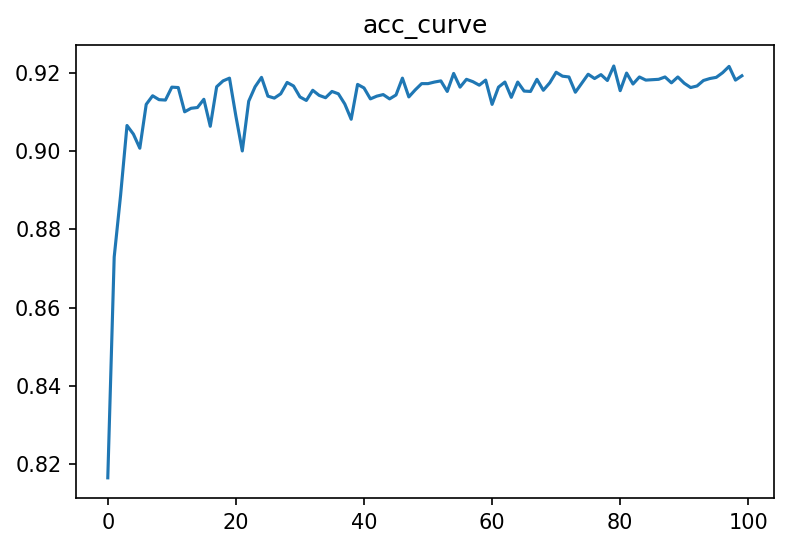

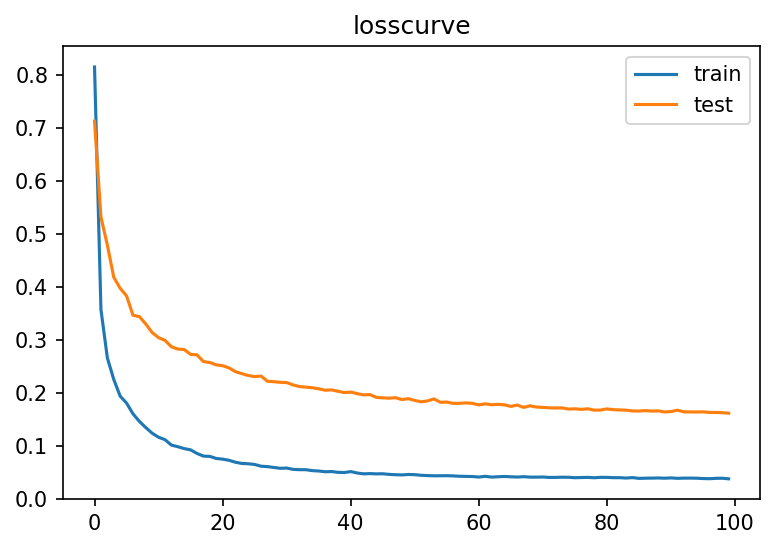

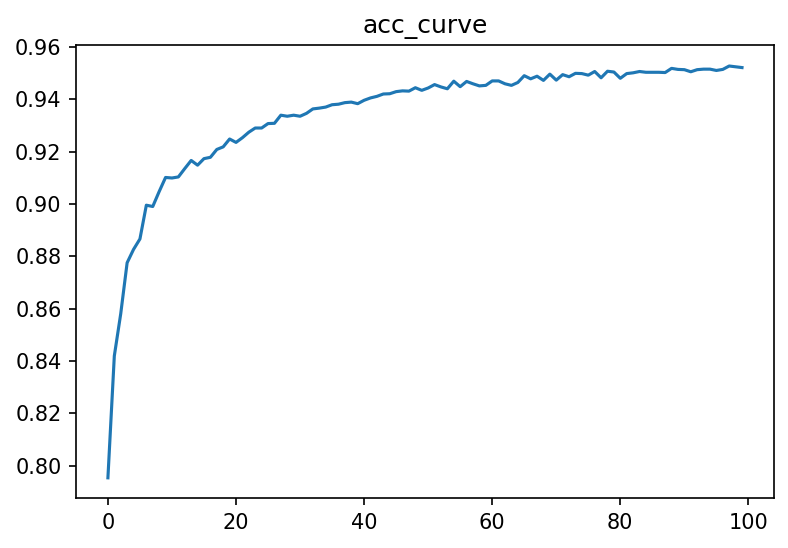

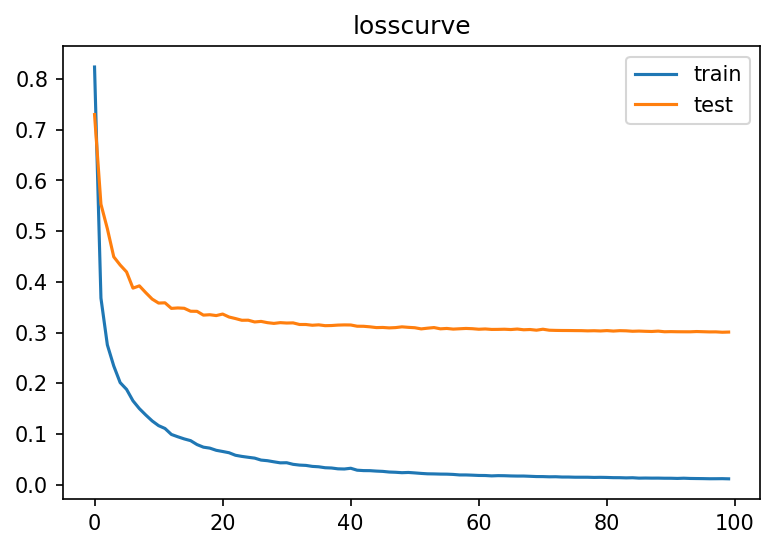

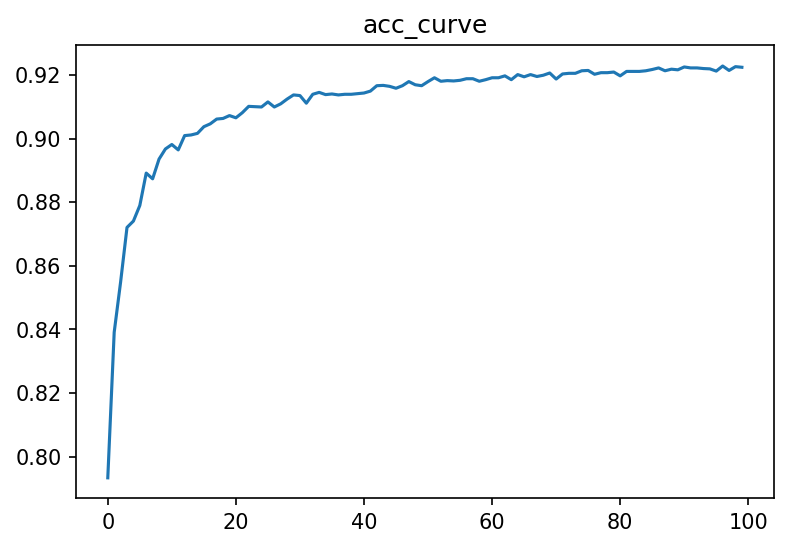

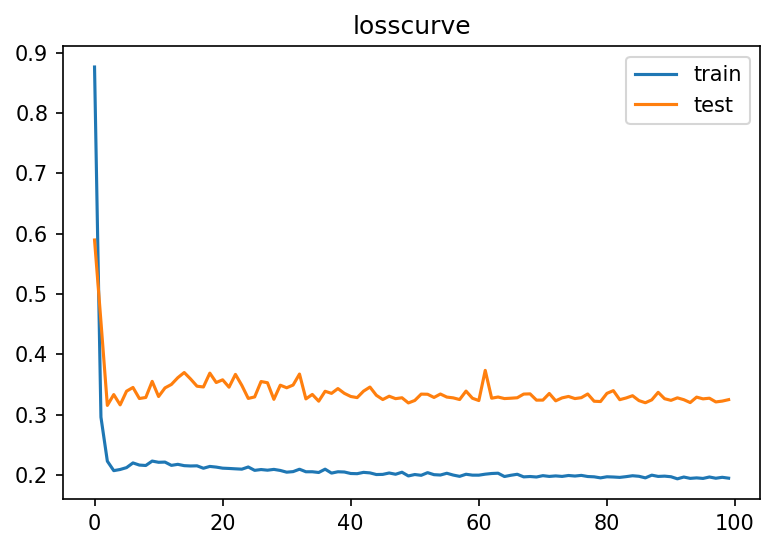

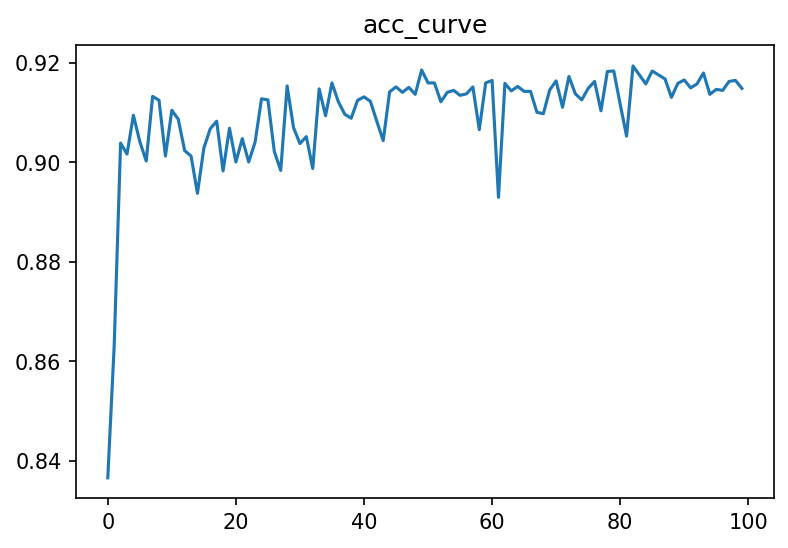

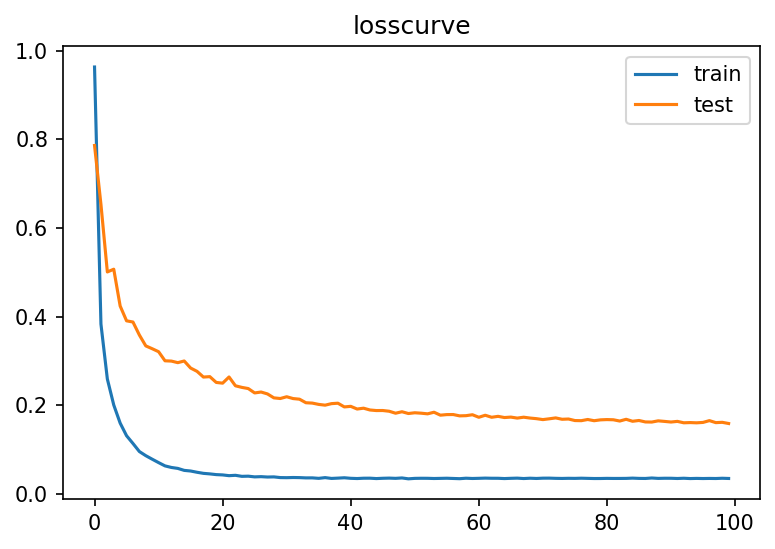

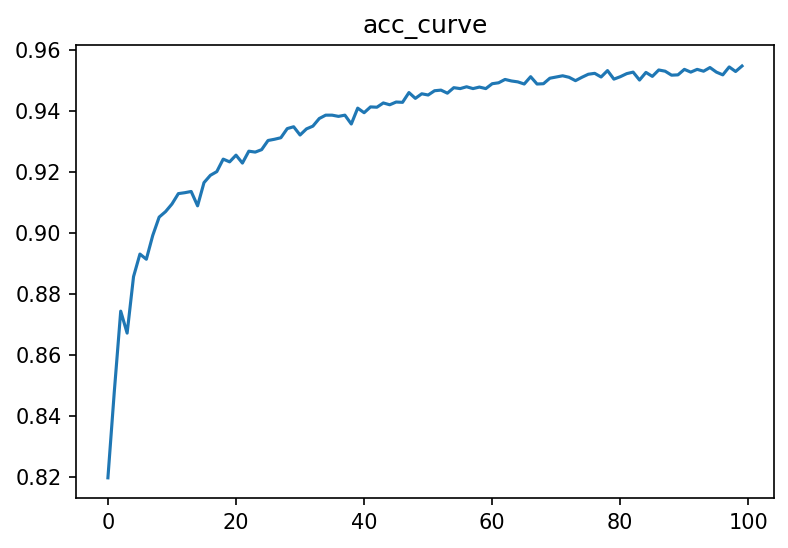

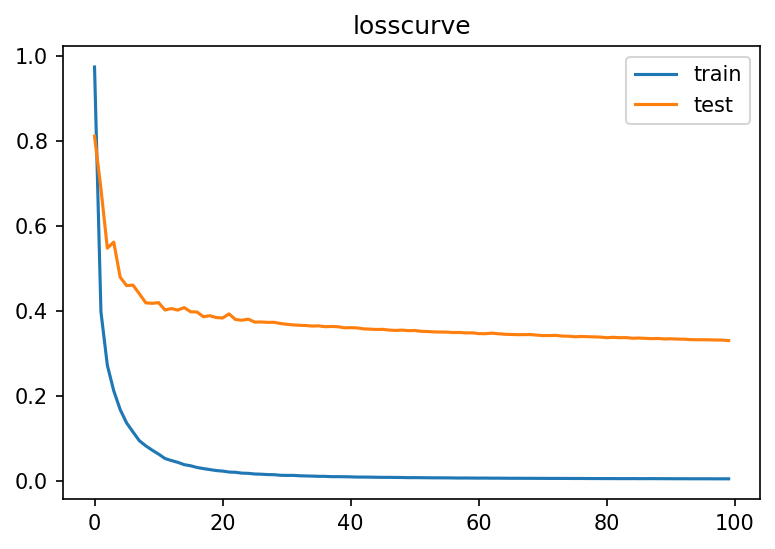

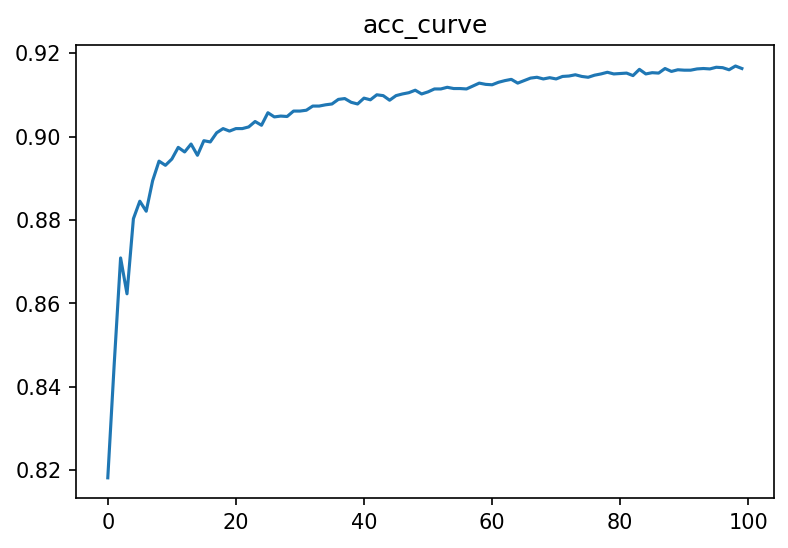

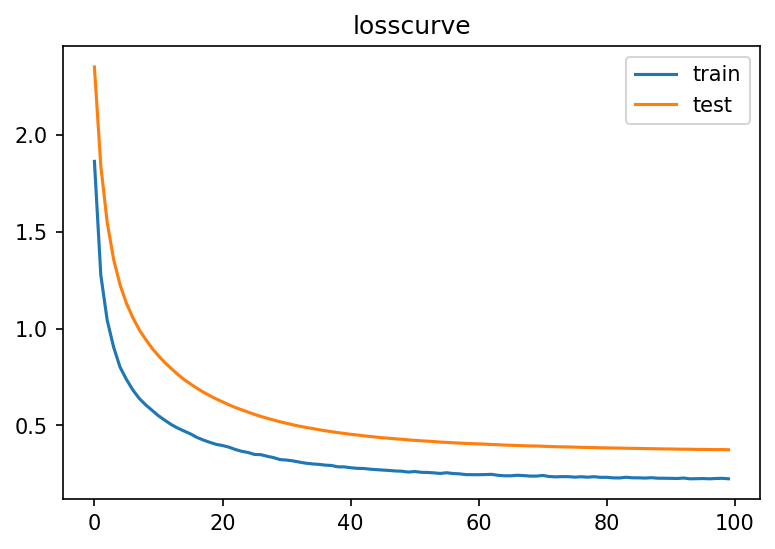

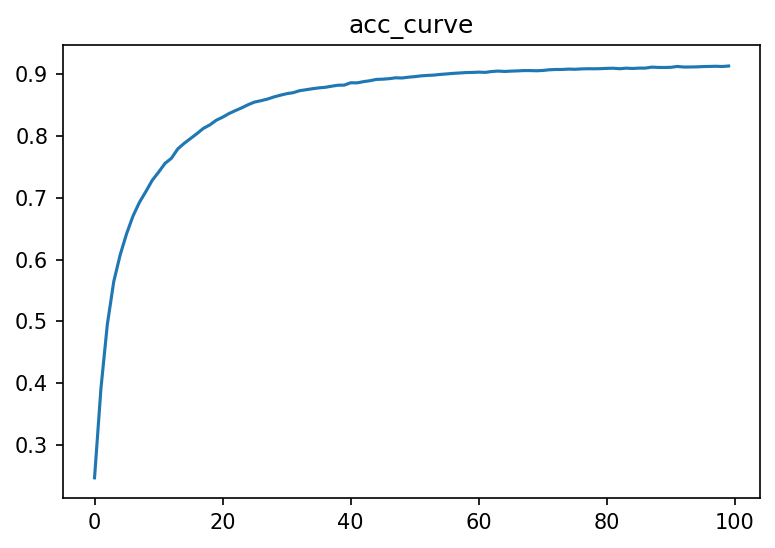

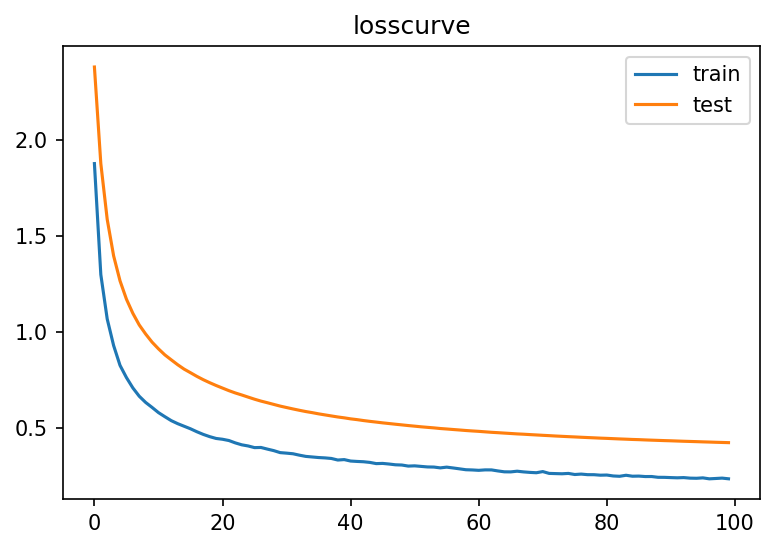

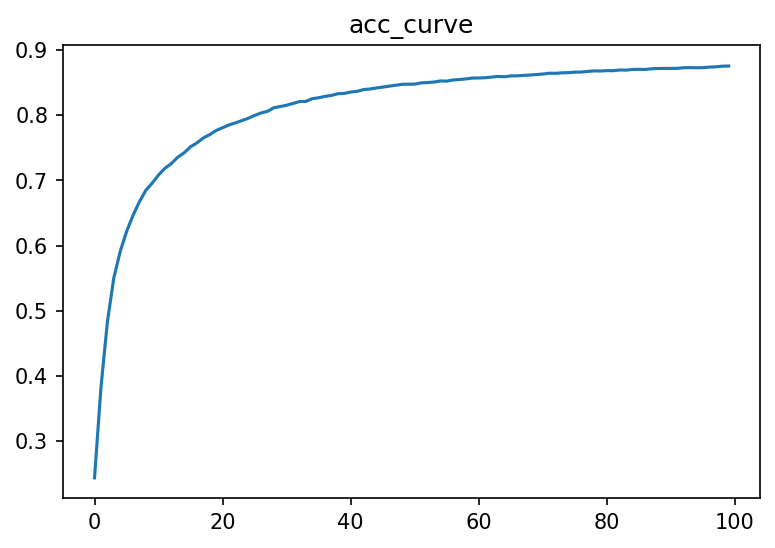

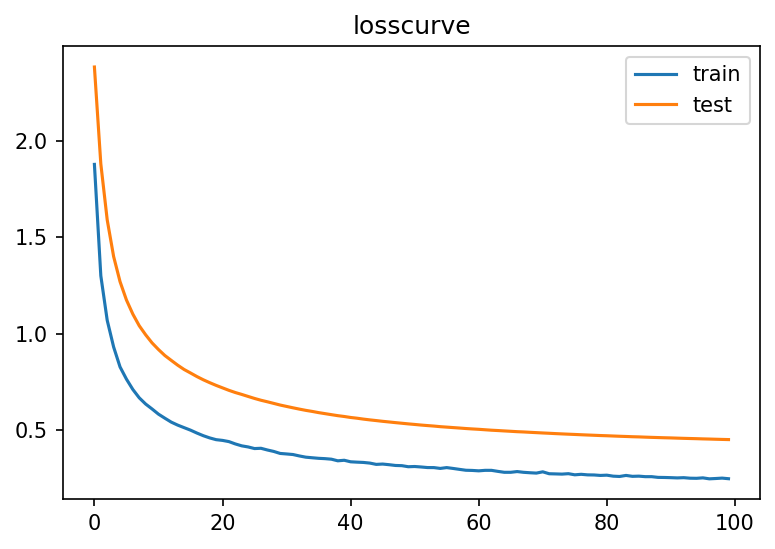

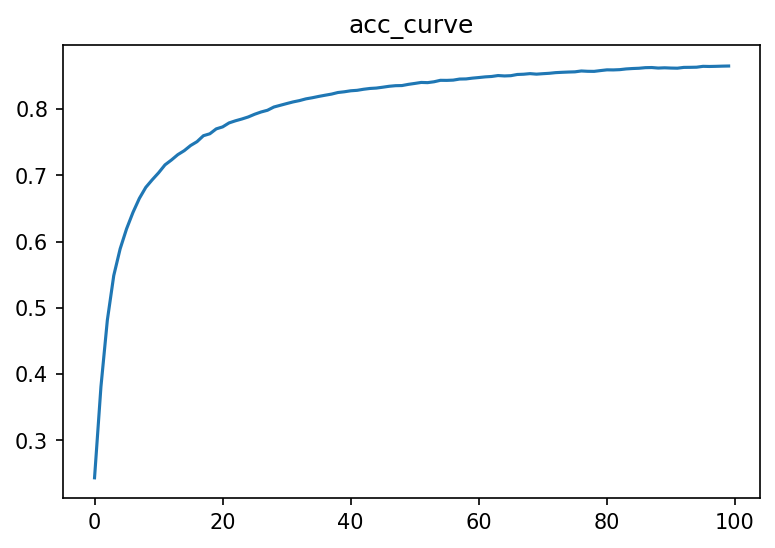

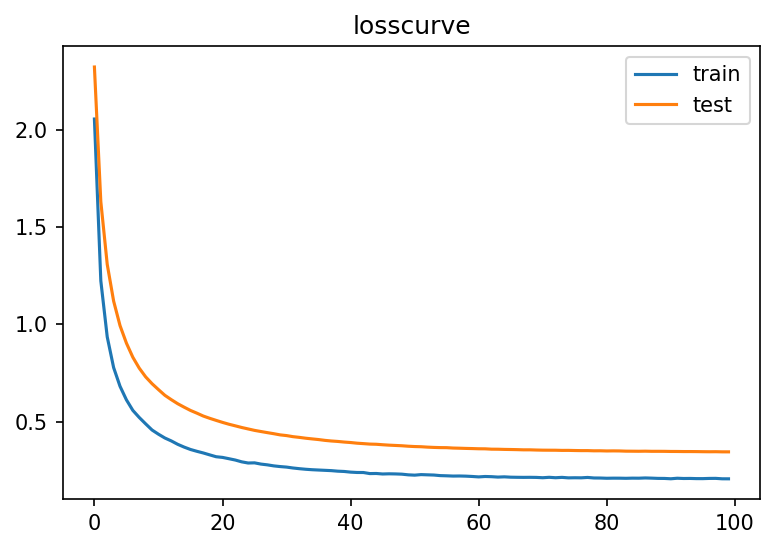

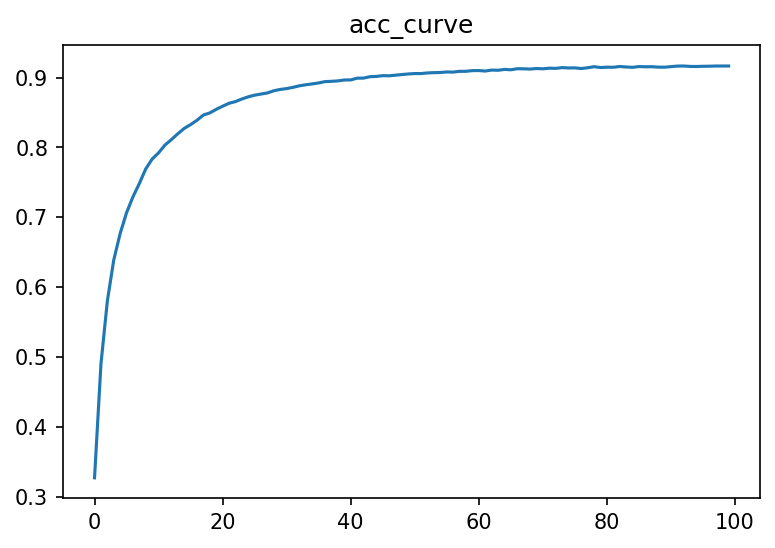

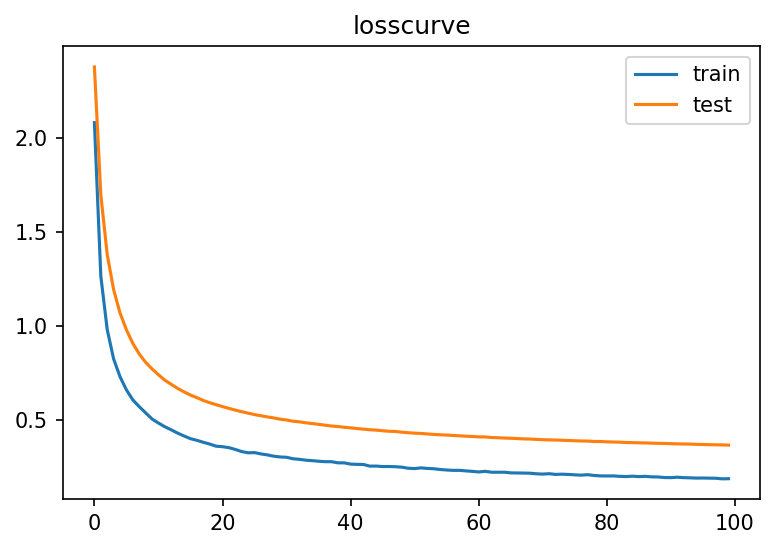

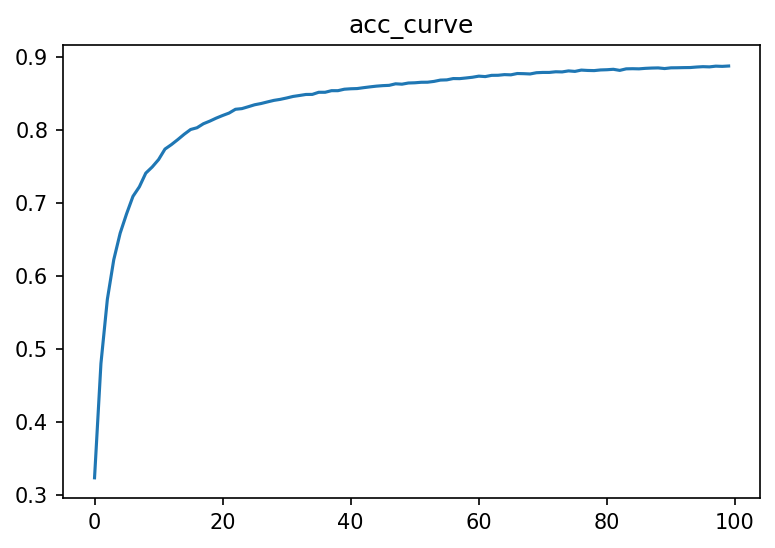

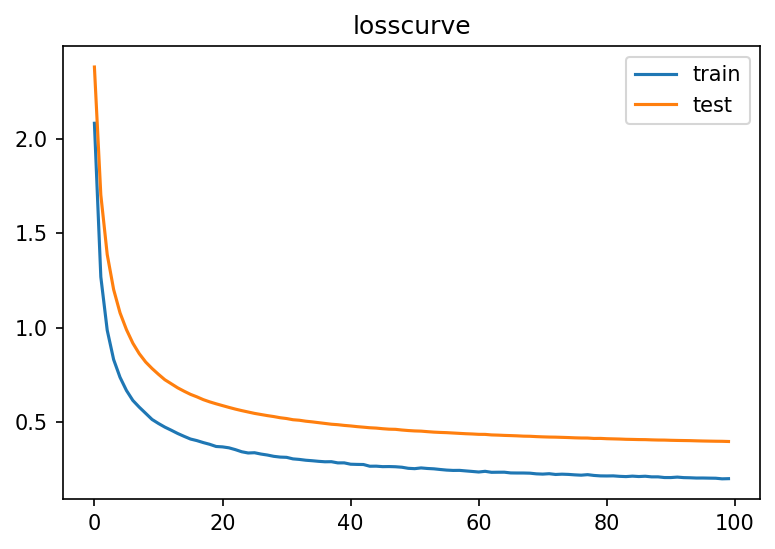

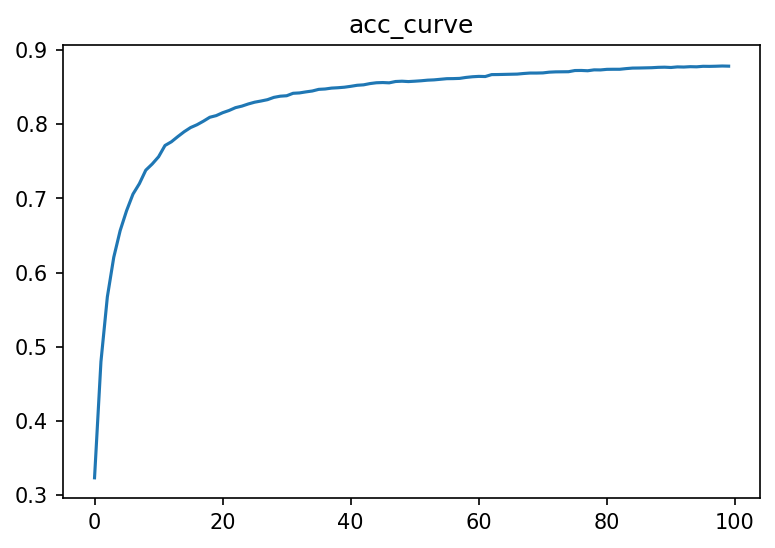

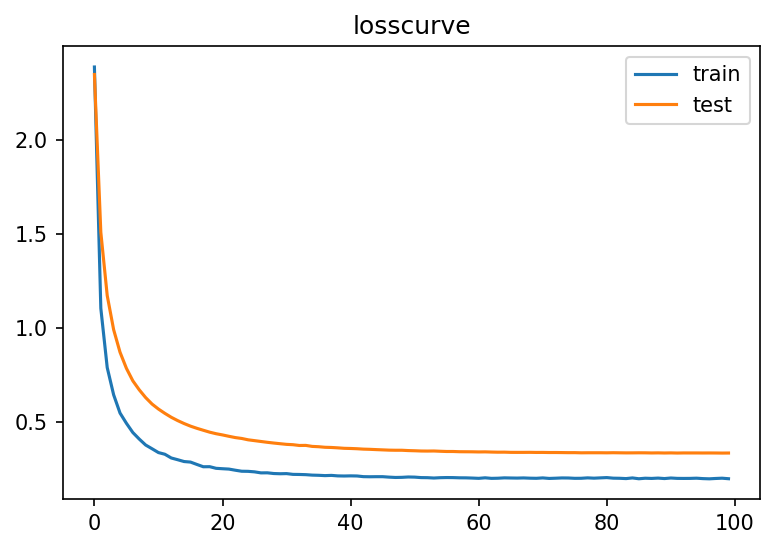

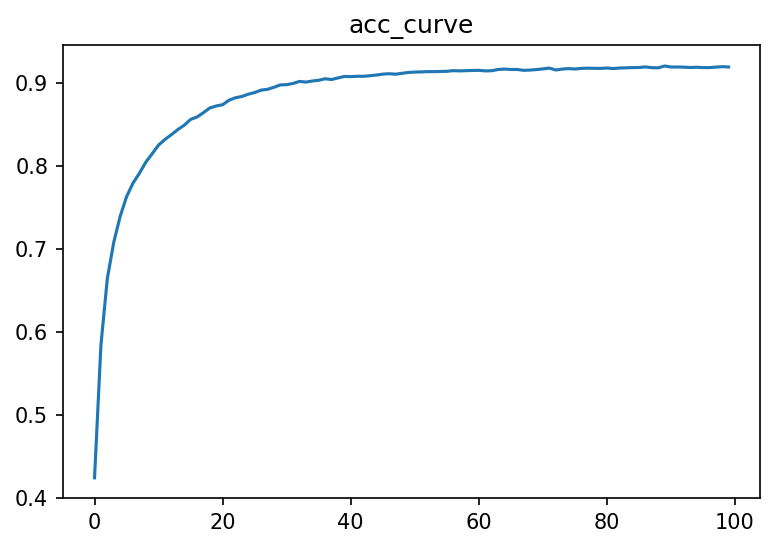

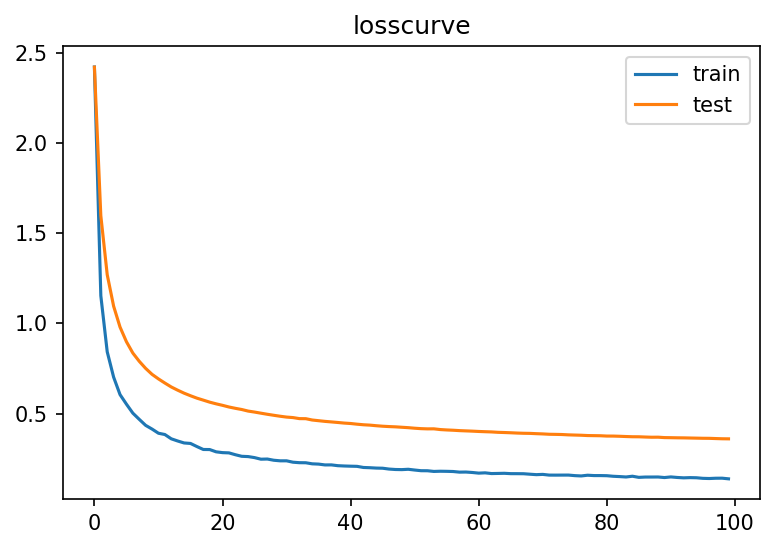

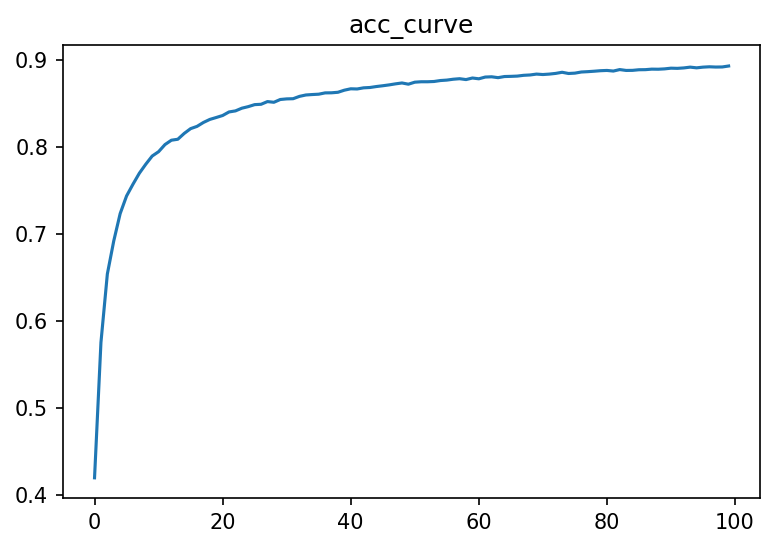

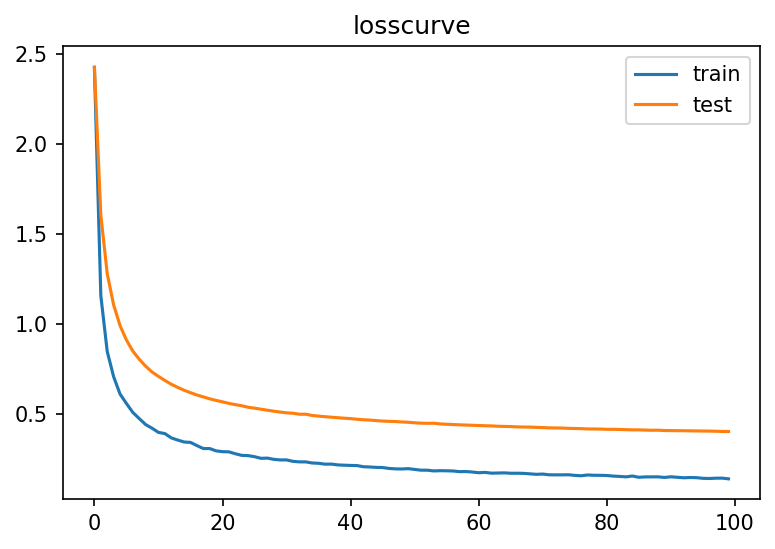

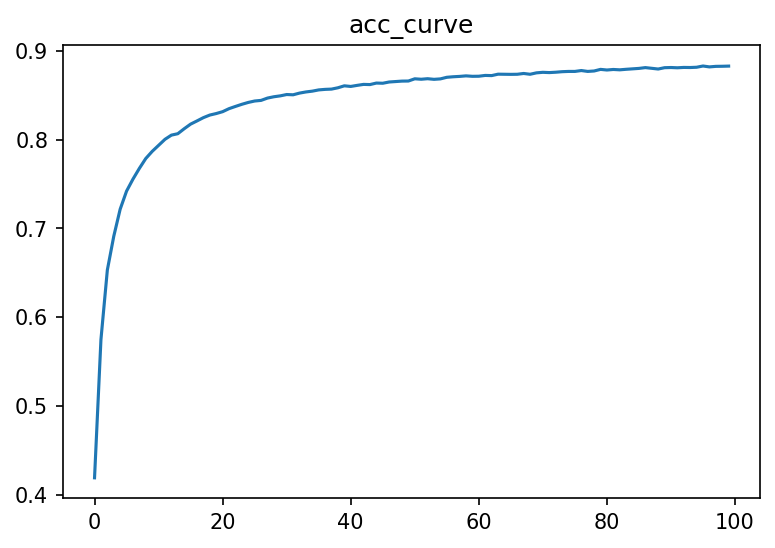

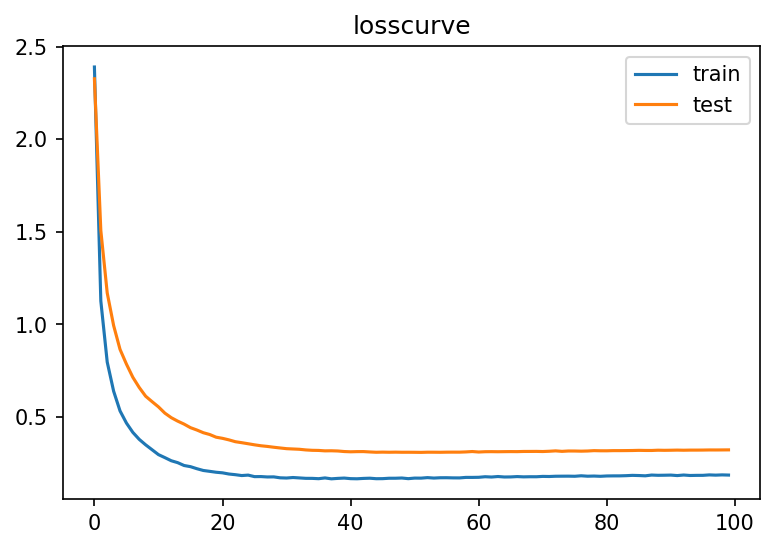

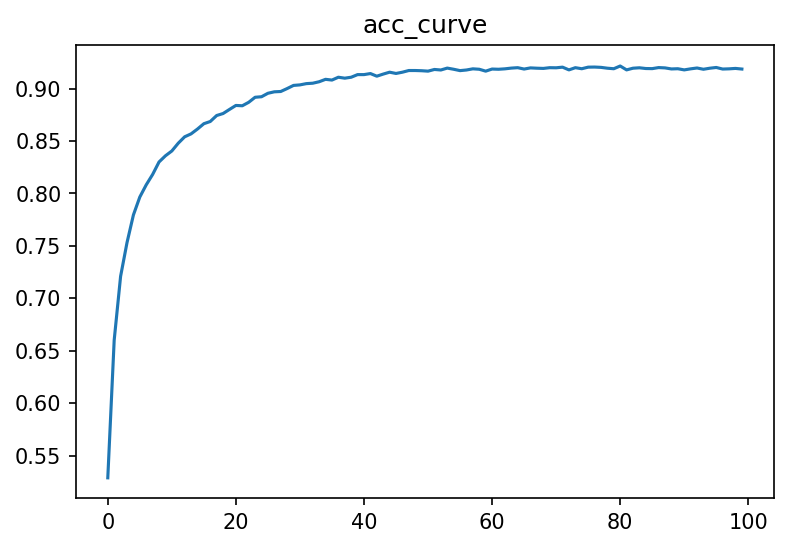

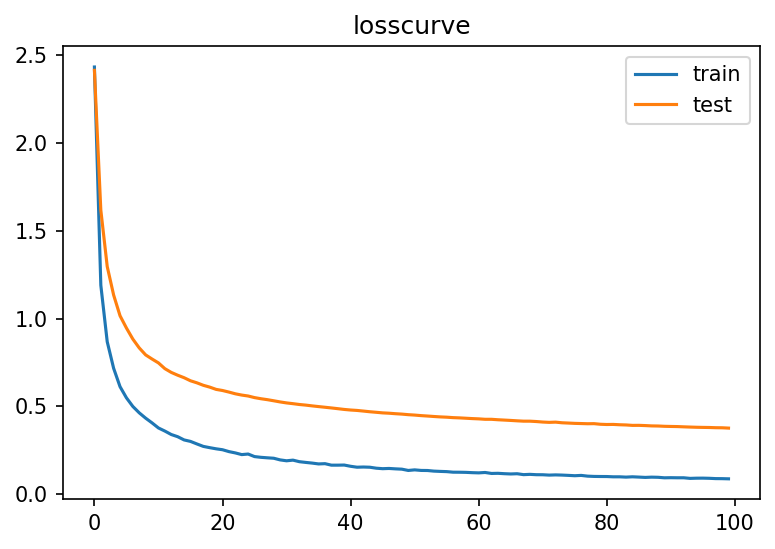

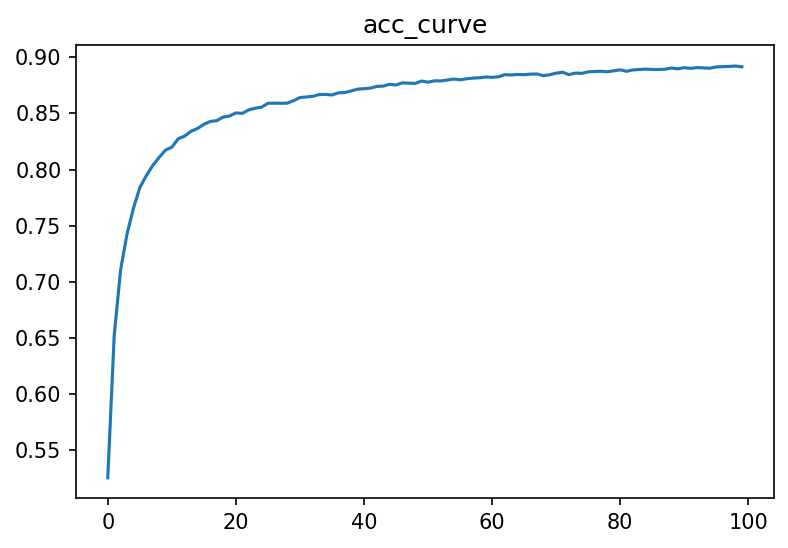

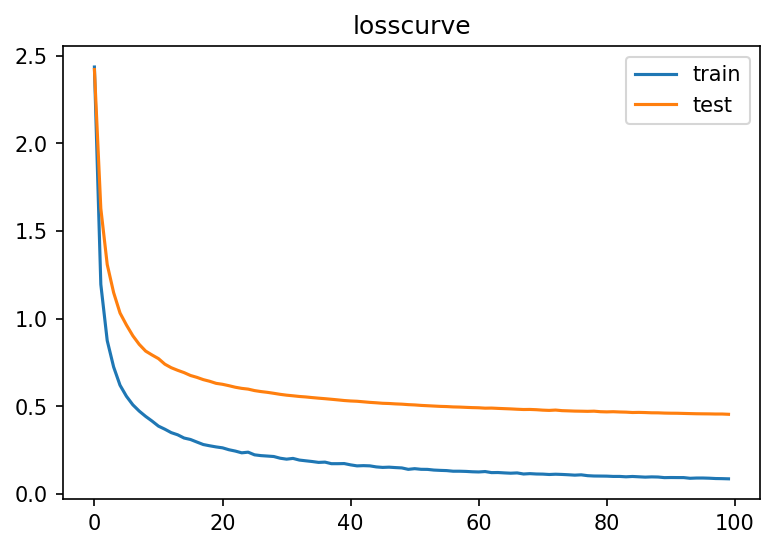

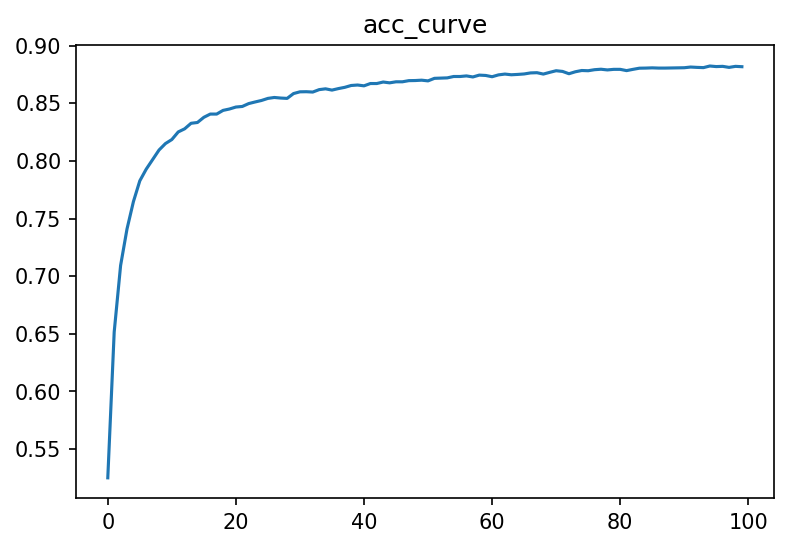

In [48]:
import numpy as np
import math
import sys, os
from pathlib import Path
import inspect



class Config:
    def __init__(self):
        self.seed = 1
        self.hidden = 250
        self.epoches = 100
        self.batch_size = 64

        self.lr_start = 0.1
        self.regularization = 0.05


def train(config):
    curr_path = '/Users/shiqifan/Desktop'
    model_path = f'{curr_path}/output/lr{config.lr_start}_hd{config.hidden}_ri{config.regularization}/'

    np.random.seed(config.seed)
    z = load_data('/Users/shiqifan/Desktop/data/mnist.pkl.gz')
    n, Input = train_X.shape
    model = NeuralNetwork(Input, config.hidden, 10, config.regularization)
    loss_train_total = []
    loss_test_total = []
    acc_total = []
    print(f'lr_start:{config.lr_start}, hiddenlayer_num:{config.hidden}, regulaization:{config.regularization}')
    for epoch in range(config.epoches):
        batch_indices = get_batch(len(test_X), config.batch_size)
        batch_num = 0
        loss_epoch = 0
        for batch in batch_indices:
            batch_num += 1
            train_X_batch = train_X[batch]
            model(train_X_batch)
            y_true = train_y[batch]
            loss_batch = float(model.loss(y_true))
            loss_epoch += 1 / len(batch_indices) * (loss_batch - loss_epoch)
            model.backward(config.lr_start, epoch)
            
        loss_train_total.append(loss_epoch)

        test_y_predict = model(test_X)
        test_loss = model.loss(test_y)
        loss_test_total.append(test_loss)
        acc = accuracy(test_y, test_y_predict)
        acc_total.append(acc)
        print(f'epoch:{epoch+1}/{config.epoches}\t   train_loss:{round(loss_epoch, 2)}\t  test_loss:{round(test_loss, 2)}\t acc:{np.round(acc*100, 2)}%.')
    Path(model_path).mkdir(parents=True, exist_ok=True)
    plot_loss(model_path, loss_train_total, loss_test_total)
    plot_acc(model_path, acc_total)
    save_metrics(model_path, loss_train_total, loss_test_total, acc_total)
    model.save(model_path+'parameters')

    print('='*25,'模型保存完成', '='*25)


if __name__ == '__main__':
    hyperparameters = ['lr', 'hidden', 'regularization']

    grid = {
        'lr': [0.1, 0.01, 0.001],
        'hidden': [25,50, 100, 200],
        'regularization': [0.1, 0.01, 0.001]
    }

    for lr_start in grid['lr']:
        for hidden in grid['hidden']:
            for regularization in grid['regularization']:
                config = Config()
                config.lr_start = lr_start
                config.hidden = hidden
                config.regularization = regularization
                train(config)